In [4]:
import time
import pyupbit
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from MarketDB import MarketDB
from datetime import datetime, timedelta
import pymysql
import warnings


pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings(action='ignore')

In [2]:
# util.py

def compare_k(df):
    """k값 비교"""
    for k in np.arange(0.1, 0.7, 0.1):
        yield (volatility(df, k), k)
        
def print_compare_k(df):
    """비교 k 값 출력"""
    for df, k in compare_k(df):
        print(round(k, 1)," : ", df['crr'].iloc[-1] * 100)
        
def get_rate(p1, p2):
    return round(((p1/p2 - 1) * 100), 2)

        
def get_next_day(date: str) -> str:
    tomorrow = datetime.strptime(date, '%Y-%m-%d') + timedelta(1)
    return tomorrow.strftime('%Y-%m-%d')

In [46]:
class VolatilityStrategy:
    
    def __init__(self, ticker, df, k, loss_cut_rate, before_day_condition):        
        self.db = MarketDB()
        self.df = self.initialize_df(df, k)
        self.ticker = ticker
        self.loss_cut_rate = loss_cut_rate
        self.before_day_condition = before_day_condition
        self.k = k
        
    def initialize_df(self, df, k):
        """과거 시세 데이터를 기반으로 백테스트에 필요한 값들을 추가한다."""
        
        df['range'] = (df['high'] - df['low']) * k
        df['target'] = df['open'] + df['range'].shift(1)
        df['ror'] = np.where(df['high'] > df['target'],
                    df['close'] / df['target'] - 0.001,
                    1)
        
        df = self.complete_df(df)
        
        return df
    
    @classmethod
    def complete_df(cls, df):
        """누적수익률, 시장 누적 수익률, mdd 추가"""
        df['hpr'] = df['ror'].cumprod()
        df['nr'] = df['close'] / df['open'] # normal rate
        df['n_hpr'] = df['nr'].cumprod() 
        df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
        df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100
        
        return df
    
    def get_loss_cut_df(self, df):
        """손절가 적용 데이터프레임 반환"""
        
        recorded_day_df = df[df['ror'] != 1]
        recorded_day_df['datetime'] = recorded_day_df.index
        
        for data in recorded_day_df.itertuples():
            date, target = datetime.strftime(data.datetime, "%Y-%m-%d"), data.target
            check = False

            for minute_data in self.db.get_ohlcv_minute1(self.ticker, get_next_day(date)).itertuples():
                if minute_data.high <= target and not check:
                    check = True

                if check:
                    if get_rate(minute_data.low, target) < self.loss_cut_rate:
                        temp = df[df.index == f'{date} 09:00:00']
                        temp.ror = 1 + (self.loss_cut_rate / 100) - 0.002 # 슬리피지+수수료 
                        df[df.index == f'{date} 09:00:00'] = temp
                    break
                    
        df = self.complete_df(df)

        return df
      
    def backtest(self, graph=True):
        """기존 전략"""
                
        if graph:
            self.visualize_return_rate(df)
        
        return self.df
    
    
    def backtest_loss_cut(self, graph=True):
        """기존 전략 + 손절가 설정 전략"""
        
        df = self.df.copy()
        df = self.get_loss_cut_df(df)
        
        if graph:
            self.visualize_return_rate(df)
        
        return df
    
    def backtest_before_day_condition(self, graph=True):
        """기존 전략 + 전날 큰 폭의 상승시 거래 제한"""
        df = self.df.copy()

        df['ror'] = np.where((df['high'] > df['target']) 
                             & ((df['close'].shift(1) / df['open'].shift(1)) < 1 + (self.before_day_condition) / 100),
                              df['close'] / df['target'] - 0.001,
                              1)
        
        df = self.complete_df(df)
        
        if graph:
            self.visualize_return_rate(df)
        
        return df
    
    def backtest_before_day_condition_and_ma20(self, graph=True):
        """기존 전략 + 전날 큰 폭의 상승시 거래 제한 + 20선 위에서만 거래 조건"""
        
        df = pyupbit.get_ohlcv(f"KRW-{self.ticker}", count=len(self.df) + 19, 
                               to=get_next_day(datetime.strftime(self.df.index[-1], "%Y-%m-%d"))) 
        
        df = self.initialize_df(df, self.k)
        
        df['ma20'] = df['close'].rolling(window=20).mean()
        df = df[df['ma20'].notna()]

        df['ror'] = np.where((df['high'] > df['target']) 
                             & ((df['close'].shift(1) / df['open'].shift(1)) < 1 + (self.before_day_condition) / 100)
                             & (df['ma20'] < df['close']),
                              df['close'] / df['target'] - 0.001,
                              1)
        
        df = self.complete_df(df)
        
        if graph:
            self.visualize_return_rate(df)
        
        return df
    
    def backtest_before_day_condition_and_ma20_and_inverse(self, graph=True):
        """기존 전략 + 전날 큰 폭의 상승시 거래 제한 + 20선 위에서만 거래 조건 + 하락장 매도 숏"""
        
        df = pyupbit.get_ohlcv(f"KRW-{self.ticker}", count=len(self.df) + 19, 
                               to=get_next_day(datetime.strftime(self.df.index[-1], "%Y-%m-%d"))) 
        
        df = self.initialize_df(df, self.k)
        df['inverse_target'] = df['open'] - df['range'].shift(1)
        
        df['ma20'] = df['close'].rolling(window=20).mean()
        df = df[df['ma20'].notna()]

        df['ror'] = np.where((df['high'] > df['target']) 
                             & ((df['close'].shift(1) / df['open'].shift(1)) < 1 + (self.before_day_condition) / 100)
                             & (df['ma20'] < df['close']),
                              df['close'] / df['target'] - 0.001,
                              1)
        
        df['ror'] = np.where((df['ma20'] > df['close'])
                             & (df['inverse_target'] > df['low']),
                             (2 - df['close'] / df['inverse_target']) - 0.001,
                             df['ror'])
        
        
        df = self.complete_df(df)
        
        if graph:
            self.visualize_return_rate(df)
        
        return df
    
    def backtest_before_day_condition_and_loss_cut(self, graph=True):
        """기존 전략 + 전날 큰 폭의 상승시 거래 제한 + 손절가 설정"""
        
        df = self.df.copy()
        df['ror'] = np.where((df['high'] > df['target']) 
                             & ((df['close'].shift(1) / df['open'].shift(1)) < 1 + (self.before_day_condition) / 100),
                              df['close'] / df['target'] - 0.001,
                              1)
        
        df = self.get_loss_cut_df(df)
        df = self.complete_df(df)
        
        
        if graph:
            self.visualize_return_rate(df)
        
        return df

    def visualize_return_rate(self, df):
        """기존 전략 적용&미적용 수익률 그래프"""
        plt.figure(figsize = (20, 8))
        plt.plot(df.index, df['hpr']*100, color = 'r', label = f"{self.ticker} ohlcv")
        plt.plot(df.index, df['n_hpr']*100, color = 'k', linestyle = '--')
        plt.legend(loc='best')
        plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
                    return_rate: {round(df['hpr'].iloc[-1] * 100 - 100, 2)}%")
        plt.ylabel("rate of return")
        plt.grid(True)
        plt.show()

    def visualize_each_stategy(self):
        """각 전략 비교 그래프"""
        
        df_basic = self.backtest(graph=False)
        df_loss_cut = self.backtest_loss_cut(graph=False)
        df_before_day_condition = self.backtest_before_day_condition(graph=False)
        df_before_day_condition_and_loss_cut = self.backtest_before_day_condition_and_loss_cut(graph=False)
        df_before_day_condition_and_ma20 = self.backtest_before_day_condition_and_ma20(graph=False)
        df_before_day_condition_and_ma20_and_inverse = self.backtest_before_day_condition_and_ma20_and_inverse(graph=False)
        
        plt.figure(figsize = (20, 10))
        plt.plot(self.df.index, df_basic['hpr']*100, color = 'g', label = "basic")
        plt.plot(self.df.index, df_loss_cut['hpr']*100, color = 'grey', label = "loss cut")
        plt.plot(self.df.index, df_before_day_condition['hpr']*100, color = 'b', label = "before_day_condition")
        plt.plot(self.df.index, df_before_day_condition_and_loss_cut['hpr']*100, color = 'y', label = "before_day_condition & loss cut")
        plt.plot(self.df.index, df_before_day_condition_and_ma20['hpr']*100, color = 'r', label = "before_day_condition & ma20 condition")
        plt.plot(self.df.index, df_before_day_condition_and_ma20_and_inverse['hpr']*100, color = 'cyan', label = "before_day_condition & ma20 condition & inverse")
        plt.plot(self.df.index, self.df['n_hpr']*100, color = 'k', linestyle = '--')

        plt.legend(loc='best')
        plt.title(f"basic mdd: {round(df_basic['mdd'].max(), 2)} return_rate: {round(df_basic['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"loss cut mdd: {round(df_loss_cut['mdd'].max(), 2)} return_rate: {round(df_loss_cut['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"before_day_condition mdd: {round(df_before_day_condition['mdd'].max(), 2)} return_rate: {round(df_before_day_condition['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"before_day_condition & loss cut mdd: {round(df_before_day_condition_and_loss_cut['mdd'].max(), 2)} return_rate: {round(df_before_day_condition_and_loss_cut['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"before_day_condition & ma20 condition mdd: {round(df_before_day_condition_and_ma20['mdd'].max(), 2)} return_rate: {round(df_before_day_condition_and_ma20['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"before_day_condition & ma20 condition & inverse mdd: {round(df_before_day_condition_and_ma20_and_inverse['mdd'].max(), 2)} return_rate: {round(df_before_day_condition_and_ma20_and_inverse['hpr'].iloc[-1] * 100 - 100, 2)}%\n"
                  f"normal mdd: {round(self.df['n_mdd'].max(), 2)} return_rate: {round(self.df['n_hpr'].iloc[-1] * 100 - 100, 2)}%")
        plt.ylabel("rate of return")
        plt.grid(True)
        plt.show()

        

# 변동성 돌파 전략의 수익을 극대화 하기 위한 +a 전략
------------------
## 가설: 20선 아래(하락장)에서 인버스 변동성 전략을 사용하면 수익률이 더 커질 것이다. 그렇지만 mdd가 커질 가능성이 있다.(선물 매도 숏)

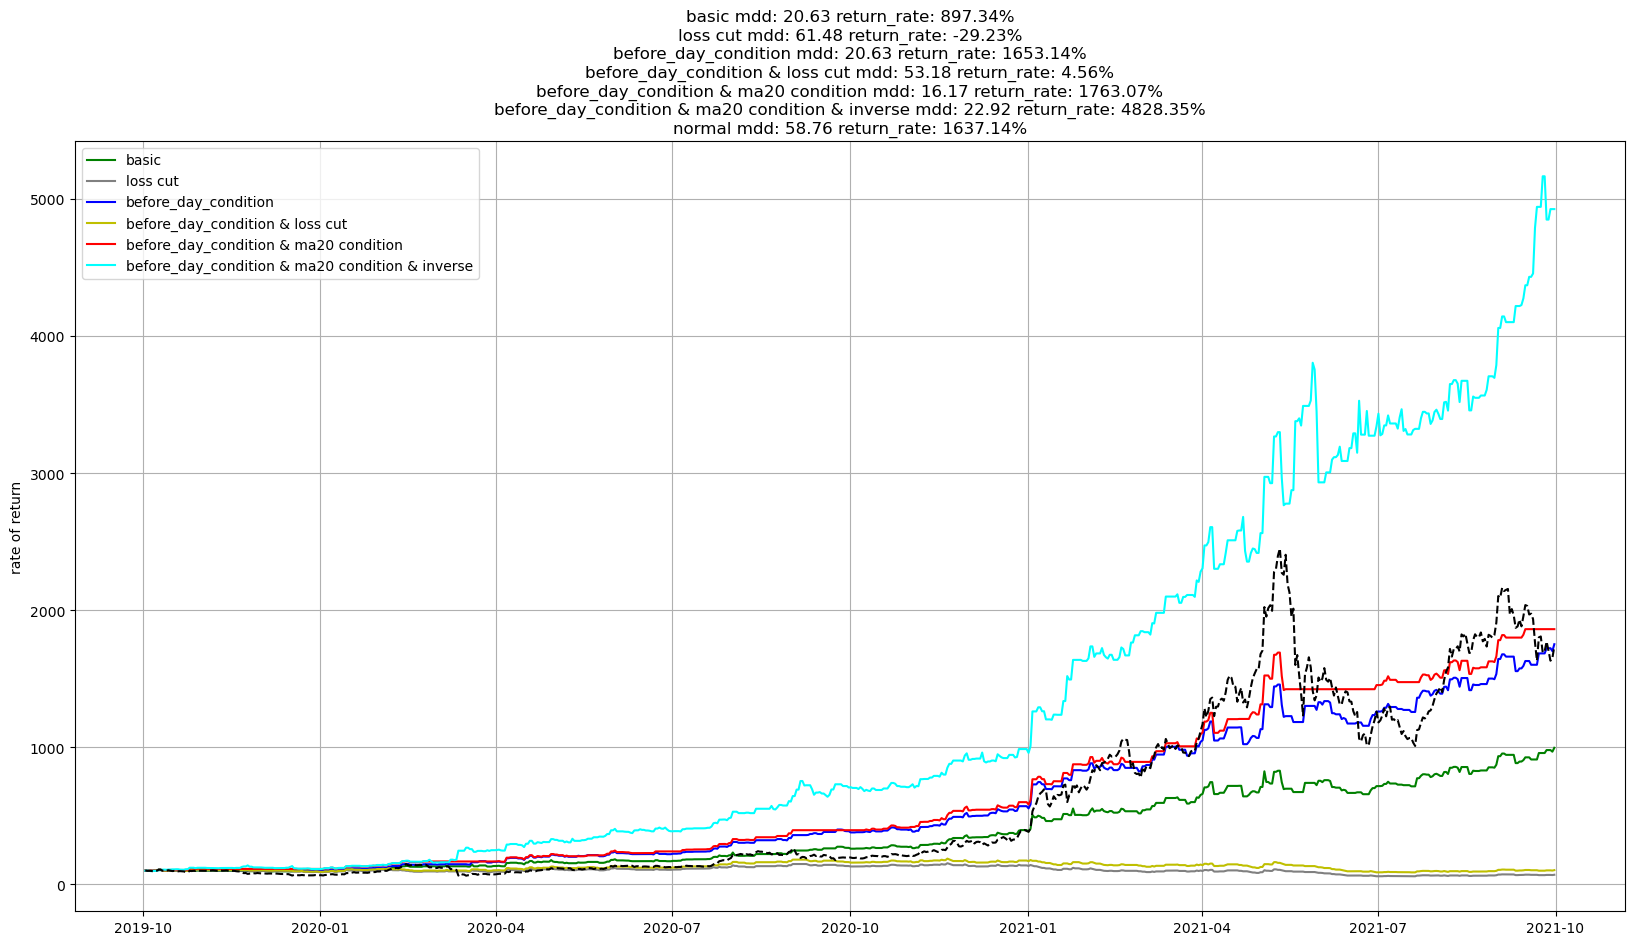

In [48]:
df = pyupbit.get_ohlcv("KRW-ETH", to="2021-10-10", count=730)

v = VolatilityStrategy(ticker="ETH", df=df, k=0.4, 
                       loss_cut_rate=-3, before_day_condition=8)

v.visualize_each_stategy()

In [ ]:
# 상승장 2021-07-20 ~ 2021-09-04  (k = 0.4)
rise_df = pyupbit.get_ohlcv("KRW-ETH", to="2021-09-04", count=46)

rise_df = volatility(rise_df, 0.4)

visualize_return_rate(rise_df, "KRW-ETH")

print_compare_k(rise_df) 

# 하락장 2021-5-11 ~ 2021-6-26

drop_df = pyupbit.get_ohlcv("KRW-ETH", to="2021-06-27", count=46)

drop_df = volatility(drop_df, 0.4)

visualize_return_rate(drop_df, "KRW-ETH")

print_compare_k(drop_df) 

# 횡보장 2021-06-01 ~ 2021-07-20
sideway_df = pyupbit.get_ohlcv("KRW-ETH", to="2020-07-21", count=49)

sideway_df = volatility(sideway_df, 0.4)

visualize_return_rate(sideway_df, "KRW-ETH")

print_compare_k(sideway_df) 

# 변동장 2021-04-23 ~ 2021-05-23

fluctuate_df = pyupbit.get_ohlcv("KRW-ETH", to="2021-05-24", count=31)

fluctuate_df = volatility(fluctuate_df, 0.4)

visualize_return_rate(fluctuate_df, "KRW-ETH")

print_compare_k(fluctuate_df) 

# 변동성 돌파 전략 보완
--------
## 한계점
- 주가가 전날 크게 상승하고 그 다음날도 랠리가 이어졌을때 과매수 상태에서 너무 높은 가격에서 거래를 한다. 결국 캔들의 윗꼬리를 달고 가격이 떨어질 수 있다. 

## 보완
- 가설1: 그날 가격 변동률이 0이 되면 손절 - 결론적으로 변동성을 돌파하려는 힘이 부족한 것으로 판단
  - 결과: 결론적으로 긴 기간으로 봤을때 mdd가 조금 떨어지지는 장점이 있었지만 수익률 또한 큰 폭으로 떨어졌다. (오히려 mdd가 더 높은 기간도 존재) 하지만 이더리움에 비해 시가총액이 작고 변동성이 큰 코인과 같은 경우에는 오히려 mdd가 낮아지고 수익률이 커지는 등의 결과를 보임
  
  
- 가설2: 전날 큰 폭으로 상승했다면 그 다음날 조정을 줄 가능성이 크기에 전날 10% 이상 급등했을 경우에는 target이 오더라도 거래를 하지 않는다.  
  - 결과: 놀라운 결과를 보임.. mdd도 낮아졌으며 수익률도 올라감. 다만 엄청난 급등에는 올라탈 수 없음.
  
  
- 가설3: 가설1과 가설2를 합친 전략은 수익률이 높을 것이다.
  - 결과: 어느 기간 어느 장에서나 통용됨. mdd는 낮으며 수익률이 좋음. 하지만 가설2만을 사용하는 것이 더 낫다 


- 가설4: 가설2를 선택할 때 mdd가 매우 커지는 구간은 상승 후 엄청난 눌림이 있을 때다. 이런 최악의 경우를 방지하기 위해 손실이 크더라도 일정 부분 손절가를 설정한다면 수익률을 높일 수 있을 것이다.  


- 가설4: 가설2를 선택할 때 mdd가 높아지는 구간의 규칙성을 파악하여 그 기간동안 거래를 하지 않는다면 수익률이 올라갈 것이다.

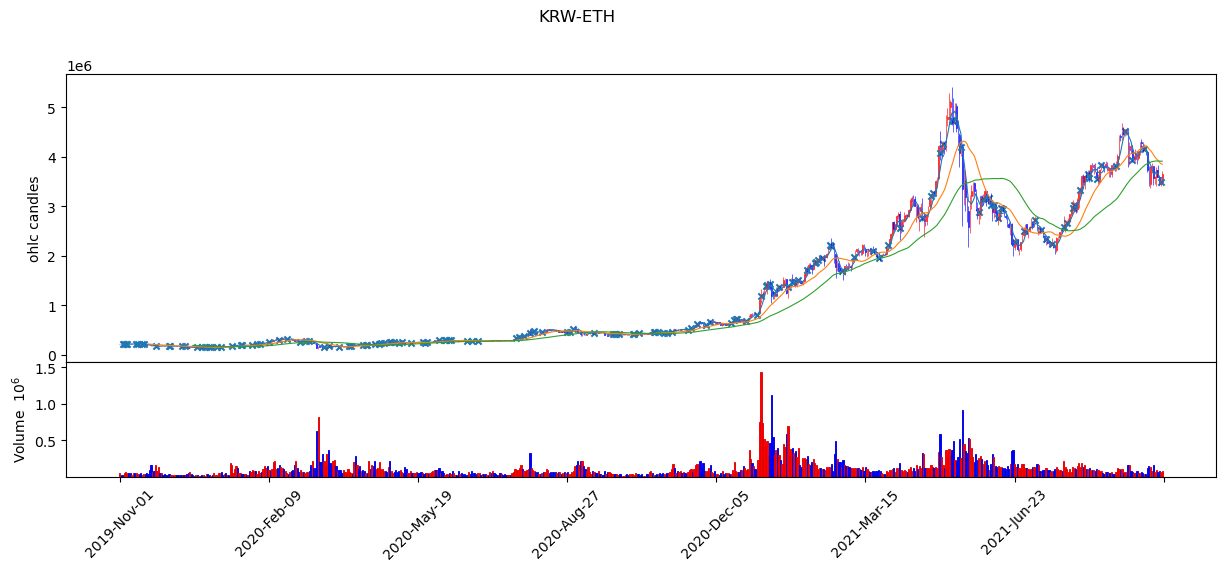

In [12]:
# 변동성돌파전략을 사용하면서 손실을 봤을 때의 특징 분석

result_df = v.backtest(graph=False)
kwargs = dict(title = "KRW-ETH" , type = 'candle', mav = (5,20,50), volume = True , ylabel= 'ohlc candles', figratio=(25,9))


mc = mpf.make_marketcolors(up = 'r' , down = 'b' , inherit = True)
s = mpf.make_mpf_style(marketcolors = mc)
scatter1 = mpf.make_addplot(np.where(result_df['ror'] < 1 ,result_df['close'] , np.nan) , type='scatter', marker='x', markersize=20, panel=0) #Issues drawing scatter
plots = [scatter1]
 
mpf.plot(result_df, **kwargs, style = s, addplot=plots)

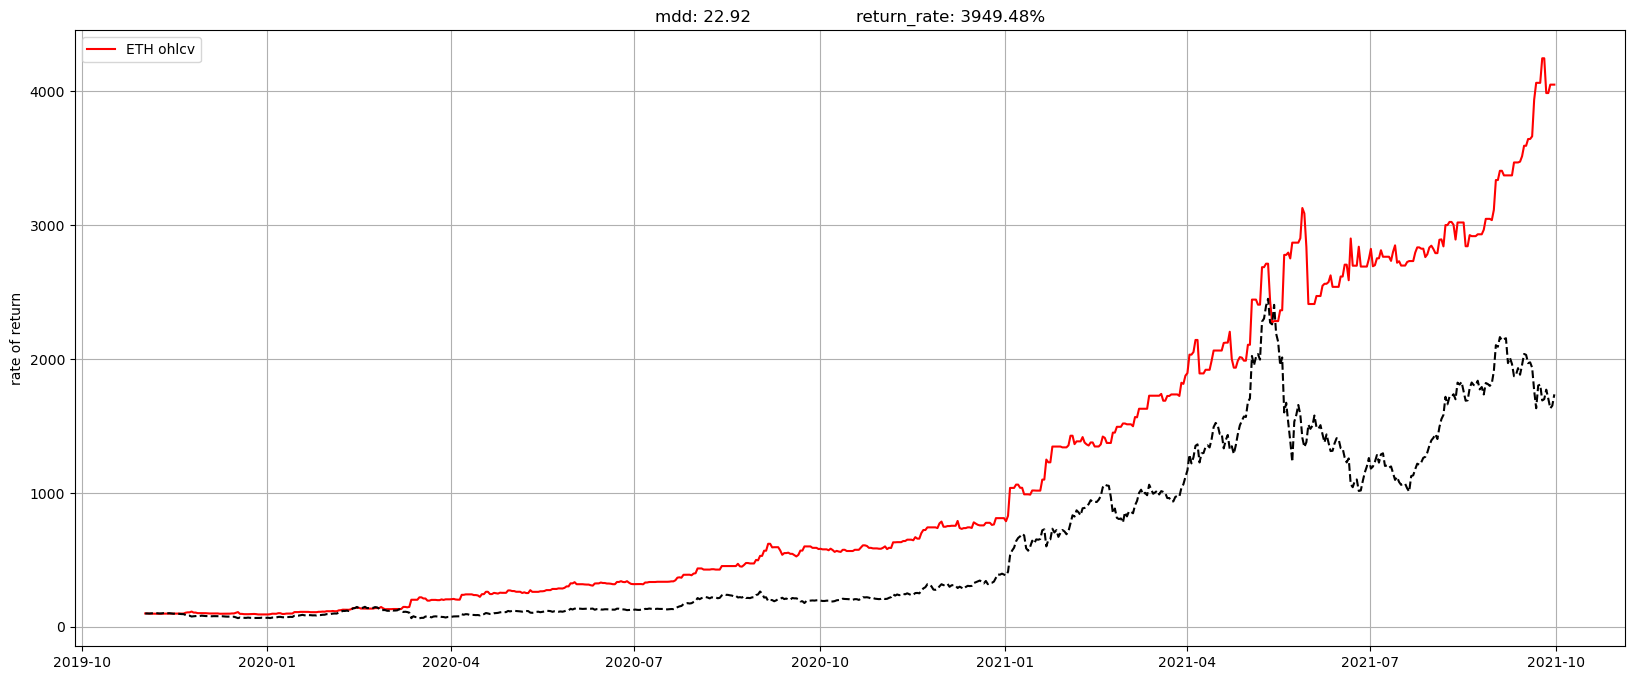

,open,high,low,close,volume,value,range,target,ror,hpr,nr,n_hpr,mdd,n_mdd,inverse_target,ma20
2019-11-01 09:00:00,213500.0,216200.0,208800.0,214000.0,5.028226e+04,1.069220e+10,2960.0,216460.0,1.000000,1.000000,1.002342,1.002342,0.000000,0.000000,210540.0,208847.5
2019-11-02 09:00:00,214100.0,216250.0,212500.0,213500.0,2.871679e+04,6.144969e+09,1500.0,217060.0,1.000000,1.000000,0.997198,0.999533,0.000000,0.280243,211140.0,208785.0
2019-11-03 09:00:00,213700.0,215250.0,209950.0,212750.0,2.912353e+04,6.199568e+09,2120.0,215200.0,0.987615,0.987615,0.995555,0.995090,1.238476,0.723545,212200.0,208377.5
2019-11-04 09:00:00,212750.0,218400.0,210500.0,214650.0,5.702048e+04,1.223278e+10,3160.0,214870.0,0.997976,0.985616,1.008931,1.003976,1.438357,0.000000,210630.0,208367.5
2019-11-05 09:00:00,214650.0,222000.0,212000.0,217850.0,6.771667e+04,1.466467e+10,4000.0,217810.0,0.999184,0.984812,1.014908,1.018944,1.518818,0.000000,211490.0,208857.5
2019-11-06 09:00:00,217950.0,223300.0,216950.0,220000.0,5.206357e+04,1.145694e+10,2540.0,221950.0,0.990214,0.975175,1.009406,1.028528,2.482531,0.000000,213950.0,209365.0
2019-11-07 09:00:00,220000.0,221300.0,212850.0,216300.0,5.105711e+04,1.105994e+10,3380.0,222540.0,1.000000,0.975175,0.983182,1.011230,2.482531,1.681818,217460.0,209915.0
2019-11-08 09:00:00,216350.0,218000.0,210500.0,213700.0,4.495462e+04,9.634081e+09,3000.0,219730.0,1.000000,0.975175,0.987751,0.998843,2.482531,2.886085,212970.0,210400.0
2019-11-09 09:00:00,213900.0,215800.0,213050.0,214950.0,2.294808e+04,4.923019e+09,1100.0,216900.0,1.000000,0.975175,1.004909,1.003747,2.482531,2.409369,210900.0,210795.0
2019-11-10 09:00:00,215300.0,222200.0,213000.0,219050.0,4.776898e+04,1.042533e+10,3680.0,216400.0,1.011246,0.986141,1.017418,1.021229,1.385865,0.709579,214200.0,211492.5


In [45]:
df = pyupbit.get_ohlcv("KRW-ETH", to="2021-10-01", count=700)

v = VolatilityStrategy(ticker="ETH", df=df, k=0.4, 
                       loss_cut_rate=-3, before_day_condition=8)

v.backtest_before_day_condition_and_ma20_and_inverse(graph=True)